# Trabajo práctico 2
## Alumno: Lucas Barrera
### Contenido
Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def create_gauss_filter(h, w, k_size, sigma):
    if k_size % 2 == 0:
        raise ValueError()

    _1d_gaussian_kernel = cv2.getGaussianKernel(k_size, sigma)
    _2d_gaussian_kernel = _1d_gaussian_kernel * _1d_gaussian_kernel.T
    spatial_filter = np.zeros((h, w))

    h_index = h//2-k_size//2
    w_index = w//2-k_size//2
    spatial_filter[h_index:h_index+k_size,
                   w_index:w_index+k_size] = _2d_gaussian_kernel

    return spatial_filter, np.fft.fft2(spatial_filter)


In [3]:
def show_spatial_filter_and_fft_transform(spatial_filter, fft_filter):
    plt.figure(figsize=(6,6))

    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title("Kernel Gausiano espacial")
    plt.imshow(spatial_filter, cmap='jet')

    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title("FFT del kernel espacial")

    tf_shifted = np.fft.fftshift(fft_filter)
    plt.imshow(np.abs(tf_shifted), cmap='jet')

#### Punto 1

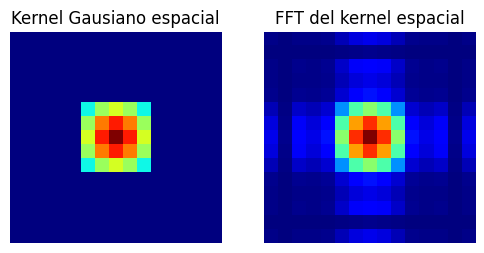

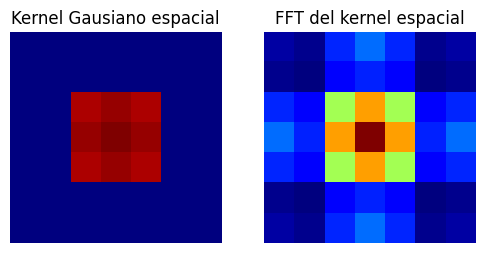

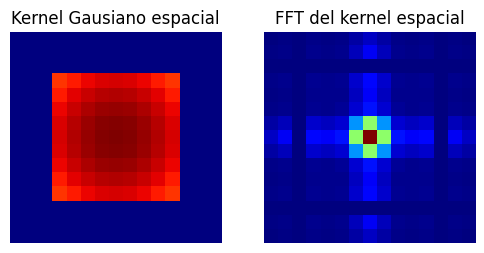

In [4]:
kernel, kernel_tf = create_gauss_filter(15, 15, 5, 2)
show_spatial_filter_and_fft_transform(kernel, kernel_tf)

kernel, kernel_tf = create_gauss_filter(7, 7, 3, 5)
show_spatial_filter_and_fft_transform(kernel, kernel_tf)

kernel, kernel_tf = create_gauss_filter(15, 15, 9, 10)
show_spatial_filter_and_fft_transform(kernel, kernel_tf)

In [5]:
def apply_fft_filter(image, fft_filter):
    image_fft = np.fft.fft2(image)
    filtered_fft = image_fft * fft_filter

    return np.fft.ifftshift(np.real(np.fft.ifft2(filtered_fft)))

In [6]:
TEST_IMAGE = './data/img2_tp.png'

Text(0.5, 1.0, 'Desenfoque gausiano spacial')

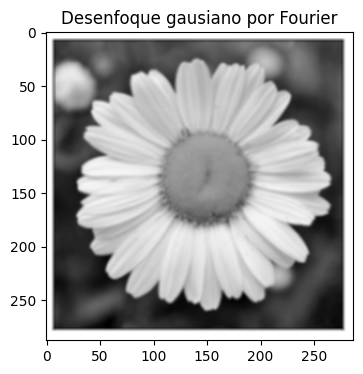

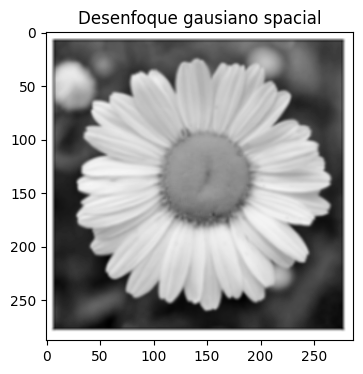

In [7]:
image = cv2.imread(TEST_IMAGE, cv2.IMREAD_GRAYSCALE)

kernetl_sp, kernel_tf = create_gauss_filter(image.shape[0], image.shape[1], 3, 10)

fft_filtered_image = apply_fft_filter(image, kernel_tf)

plt.figure(figsize=(4,4))
plt.imshow(fft_filtered_image, cmap='gray')
plt.title('Desenfoque gausiano por Fourier')

sp_filtered_image = cv2.filter2D(image, ddepth=-1, kernel=kernetl_sp)

plt.figure(figsize=(4,4))
plt.imshow(sp_filtered_image, cmap='gray')
plt.title('Desenfoque gausiano spacial')

#### Punto 2

In [8]:
# Obtenido desde "Image Sharpness Measure for Blurred Images in Frequency Domain"
def get_image_quality_measure(image):
    image_fft = np.fft.fft2(image)
    image_fft_shifted = np.fft.fftshift(image_fft)
    m = np.max(np.abs(image_fft_shifted))
    thres = m/1000
    th = len(image_fft[image_fft>thres])
    return th/image.size
    

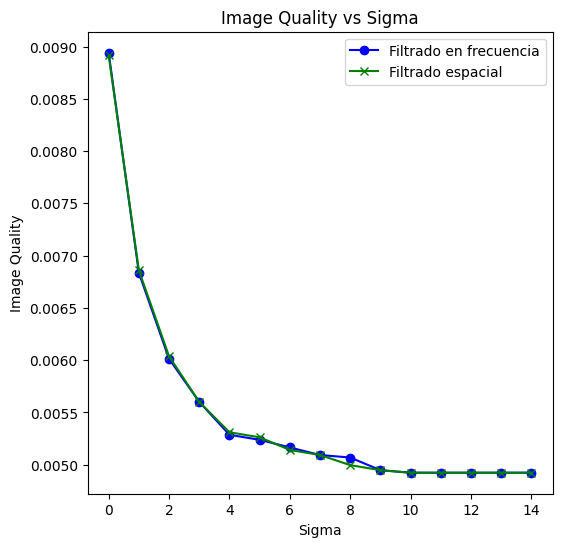

In [9]:
image = cv2.imread(TEST_IMAGE, cv2.IMREAD_GRAYSCALE)

iqm_ffts = []
iqm_sps = []

for sigma in np.linspace(1.0, 8.0, num=15):
    kernetl_sp, kernel_tf = create_gauss_filter(image.shape[0], image.shape[1], 7, sigma)
    
    fft_filtered_image = apply_fft_filter(image, kernel_tf)
    iqm_fft = get_image_quality_measure(fft_filtered_image)

    sp_filtered_image = cv2.filter2D(image, ddepth=-1, kernel=kernetl_sp)
    iqm_sp = get_image_quality_measure(sp_filtered_image)

    iqm_ffts.append(iqm_fft)
    iqm_sps.append(iqm_sp)

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Image Quality vs Sigma')
ax.plot(iqm_ffts, '-bo', label='Filtrado en frecuencia')
ax.plot(iqm_sps, '-gx', label='Filtrado espacial')
plt.xlabel('Sigma')
plt.ylabel('Image Quality')
ax.legend()


#### Punto 3

In [10]:
np.histogram([2,3,4,0], 4, [0, 4])

(array([1, 0, 1, 2], dtype=int64), array([0., 1., 2., 3., 4.]))

In [11]:
def get_absolute_central_moment(image):
    histogram, _ = np.histogram(image[:, :].ravel(), 256, [0, 256])
    n_pixels = len(image[:, :].ravel())

    mean = np.mean(image)
    
    ACMo = 0

    for i in range(1, 256 + 1):
        ACMo += np.abs(i - mean)*histogram[i-1]
    
    return ACMo/n_pixels

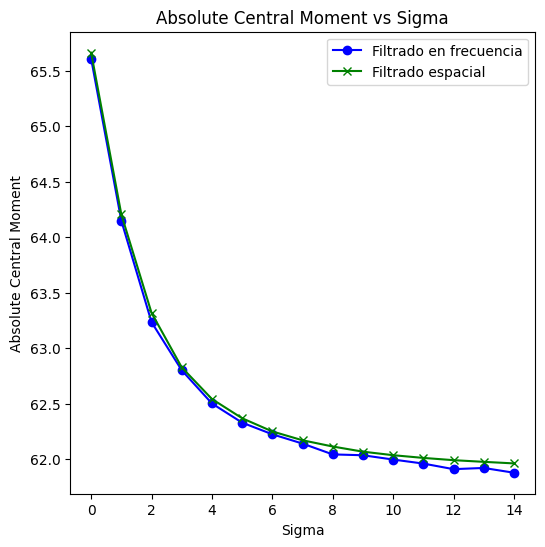

In [12]:
image = cv2.imread(TEST_IMAGE, cv2.IMREAD_GRAYSCALE)

bfm_ffts = []
bfm_sps = []

for sigma in np.linspace(1.0, 8.0, num=15):
    kernetl_sp, kernel_tf = create_gauss_filter(image.shape[0], image.shape[1], 7, sigma)
    
    fft_filtered_image = apply_fft_filter(image, kernel_tf)
    bfm_fft = get_absolute_central_moment(fft_filtered_image)

    sp_filtered_image = cv2.filter2D(image, ddepth=-1, kernel=kernetl_sp)
    bfm_sp = get_absolute_central_moment(sp_filtered_image)

    bfm_ffts.append(bfm_fft)
    bfm_sps.append(bfm_sp)

fig, ax = plt.subplots(1, figsize=(6, 6))
ax.set_title('Absolute Central Moment vs Sigma')
ax.plot(bfm_ffts, '-bo', label='Filtrado en frecuencia')
ax.plot(bfm_sps, '-gx', label='Filtrado espacial')
plt.xlabel('Sigma')
plt.ylabel('Absolute Central Moment')
ax.legend()